## Setup Environment
### Import Libraries

In [1534]:
import json
import math
import numpy as np
from scipy import signal
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
import scipy.signal as signal

In [1535]:
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)

## Load recorded data into the environment and display the available links

In [1536]:
def JsonLoad(folder, json_file):
    '''
    Load parameters from the saved json file
    INPUT
    ----
        folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
        json_file: the json file with all the specifications. Example: '/save_iq_w_tx_gold.json'
    OUTPUT
    ----
        samps_per_chip: samples per chip
        wotxrepeat: number of repeating IQ sample collection w/o transmission. Used as an input to 
        traverse_dataset() func
        rxrate: sampling rate at the receiver side
    '''
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']

    return rxrepeat, rxrate, txnodes, rxnodes


In [1537]:
def traverse_dataset(meas_folder):
    '''
    Load data from hdf5 format measurement file
    INPUT
    ----
        meas_folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
    OUTPUT
    ----
        data: Collected IQ samples w/ transmission. It is indexed by the transmitter name
        noise: Collected IQ samples w/o transmission. It is indexed by the transmitter name
        txrxloc: transmitter and receiver names
    '''
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r") #meas_folder
    print("Dataset meta data:", list(dataset.attrs.items()))
    for cmd in dataset.keys():
        print("Command:", cmd)
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for rx_gain in dataset[cmd][cmd_time].keys():
                print("   RX gain:", rx_gain)
                for rx in dataset[cmd][cmd_time][rx_gain].keys():
                    print("     RX:", rx)
                    print("       Measurement items:", list(dataset[cmd][cmd_time][rx_gain][rx].keys()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                print("   TX:", tx)
                
                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("       RX gain:", rx_gain)
                        #print(dataset[cmd][cmd_time][tx][rx_gain].keys())
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            print("         RX:", rx)
                            print("           Measurement items:", list(dataset[cmd][cmd_time][tx][rx_gain][rx].keys()))
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            print("         repeat", repeat)

                            samplesNotx =  dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("     TX gain:", tx_gain)
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            print("       RX gain:", rx_gain)
                            #print(dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys())
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                print("         RX:", rx)
                                print("         Measurement items:", list(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx].keys()))
                                print("         samples shape", np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples']))
                                # print("         rxloc", (dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxloc'][0]))
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                print("         repeat", repeat)

                                # peak avg check
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))

        else:                       
            print('Unsupported command: ', cmd)

    return data, noise, txrxloc

In [1538]:
# Plot the dataset
def plotAllLinks(rx_data, txrxloc):

    # rx_data is a dict indexed by transmitter name
    for txloc in rx_data:
        # check one specific transmitter
        # if txloc != 'cbrssdr1-hospital-comp':continue
        #print('TX: {}'.format(txloc))
        rx_data[txloc] = np.vstack(rx_data[txloc])
        #print('[Debug] data shape', np.shape(rx_data[txloc]))
        txrxloc[txloc] = np.vstack(txrxloc[txloc]).flatten()
            
        # measurements vs. distance
        # plt.figure()
        for j, rxloc in enumerate(txrxloc[txloc][::rxrepeat]):
            # check one specific receiver
            # if rxloc != 'cnode-wasatch-dd-b210':continue
            print('RX: {}'.format(rxloc))

            namelist = (rxloc.split('-'))
            TXnamelist = (txloc.split('-'))
                
            # custom processing functions implemented here
            plt.figure(figsize=(5,4))
            plt.plot(np.abs(rx_data[txloc][j,:]))
            plt.title('TX: {} RX: {}'.format(TXnamelist[1], namelist[1]))
            plt.ylabel('ampltiude')
            plt.xlabel('Sample Index')
            plt.tight_layout()

            plt.figure(figsize=(5,4))
            plt.plot(np.angle(rx_data[txloc][j,:]))
            plt.ylabel('angle')
            plt.xlabel('Sample Index')
            plt.title('TX: {} RX: {}'.format(TXnamelist[1], namelist[1]))
            plt.tight_layout()

            plt.figure(figsize=(5,4))
            plt.psd(rx_data[txloc][j,:], Fs = 240)
            plt.title('TX: {} RX: {}'.format(TXnamelist[1], namelist[1]))
            plt.xlabel('Frequency (KHz)')
            plt.tight_layout()
    plt.show()

In [1539]:
# load parameters from the json script
folder = "Shout_meas/Shout_meas_01-20-2023_00-40-44"
jsonfile = 'save_iq_w_tx_file.json'
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)

# load data from the .json, save IQ sample arrays and tx/rx names
rx_data, _, txrxloc = traverse_dataset(folder)

Dataset meta data: [('shout_version', '5c5accf')]
Command: saveiq_w_tx
  Timestamp: 01-20-2023, 01:40:46
  Command meta data: [('cmd', 'save_iq_w_tx'), ('nsamps', 8192), ('rxfreq', 3455000000.0), ('rxgain', 30.0), ('rxrate', 250000.0), ('rxrepeat', 4), ('rxwait_max', 2000), ('rxwait_min', 50), ('rxwait_random', True), ('rxwait_res', 'ms'), ('start_time', 1674200452.0), ('sync', True), ('timeout', 30), ('timezone', 'US/Mountain'), ('txfile', '/users/wjcqmz/QPSK_signal_2023_01_18_neal.iq'), ('txfreq', 3455000000.0), ('txgain', 27.0), ('txrate', 250000.0), ('txwait', 3), ('use_lo_offset', True), ('wotxrepeat', 0)]
   TX: cbrssdr1-bes-comp
     TX gain: 27.0
       RX gain: 30.0
         RX: cbrssdr1-browning-comp
         Measurement items: ['rxsamples', 'rxtime']
         samples shape (4, 8192)
         repeat 4
         RX: cbrssdr1-fm-comp
         Measurement items: ['rxsamples', 'rxtime']
         samples shape (4, 8192)
         repeat 4
         RX: cbrssdr1-honors-comp
         M

RX: cbrssdr1-browning-comp
RX: cbrssdr1-fm-comp
RX: cbrssdr1-honors-comp
RX: cbrssdr1-hospital-comp
RX: cbrssdr1-smt-comp
RX: cbrssdr1-ustar-comp
RX: cbrssdr1-bes-comp
RX: cbrssdr1-fm-comp
RX: cbrssdr1-honors-comp
RX: cbrssdr1-hospital-comp


/var/folders/5q/f6g28mk50hs4nm7bw7cqrgch0000gq/T/ipykernel_18492/3140191978.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))


RX: cbrssdr1-smt-comp
RX: cbrssdr1-ustar-comp
RX: cbrssdr1-bes-comp
RX: cbrssdr1-browning-comp
RX: cbrssdr1-honors-comp
RX: cbrssdr1-hospital-comp
RX: cbrssdr1-smt-comp
RX: cbrssdr1-ustar-comp
RX: cbrssdr1-bes-comp
RX: cbrssdr1-browning-comp
RX: cbrssdr1-fm-comp
RX: cbrssdr1-hospital-comp
RX: cbrssdr1-smt-comp
RX: cbrssdr1-ustar-comp
RX: cbrssdr1-bes-comp
RX: cbrssdr1-browning-comp
RX: cbrssdr1-fm-comp
RX: cbrssdr1-honors-comp
RX: cbrssdr1-smt-comp
RX: cbrssdr1-ustar-comp
RX: cbrssdr1-bes-comp
RX: cbrssdr1-browning-comp
RX: cbrssdr1-fm-comp
RX: cbrssdr1-honors-comp
RX: cbrssdr1-hospital-comp
RX: cbrssdr1-ustar-comp
RX: cbrssdr1-bes-comp
RX: cbrssdr1-browning-comp
RX: cbrssdr1-fm-comp
RX: cbrssdr1-honors-comp
RX: cbrssdr1-hospital-comp
RX: cbrssdr1-smt-comp


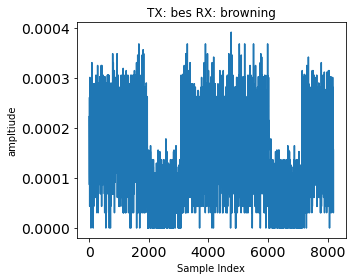

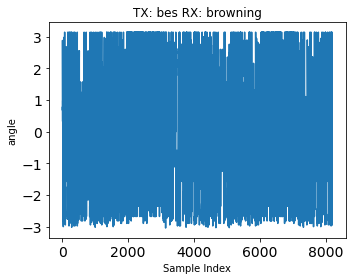

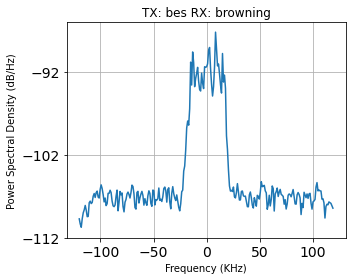

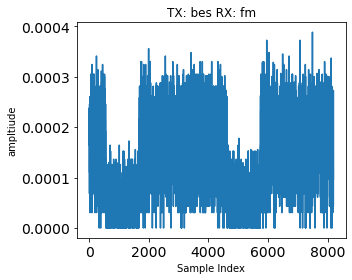

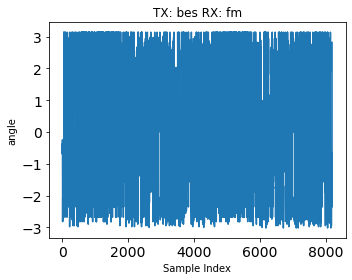

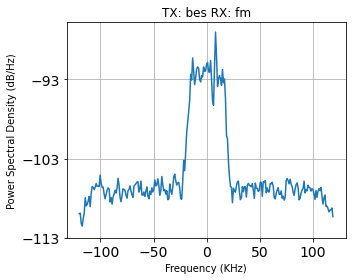

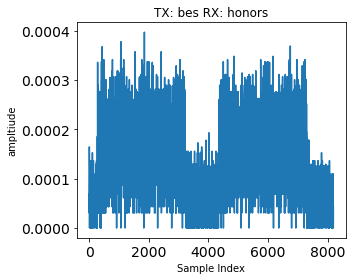

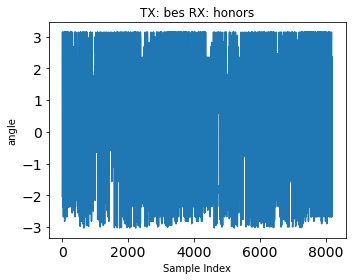

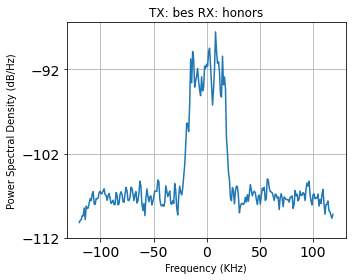

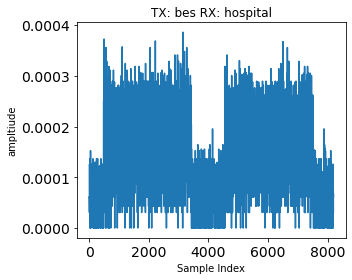

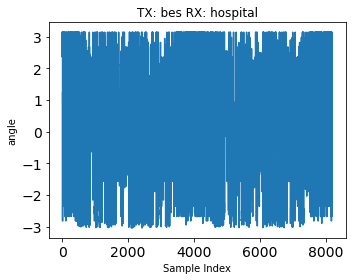

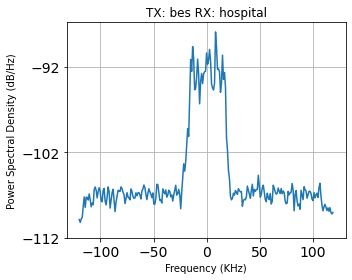

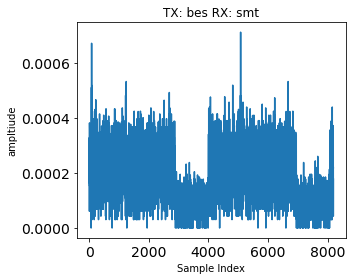

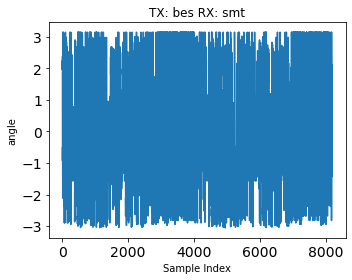

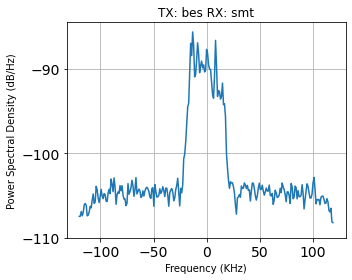

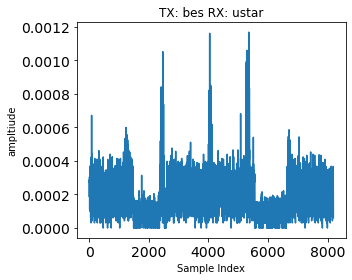

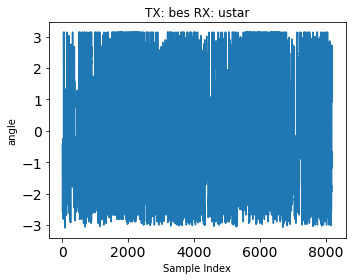

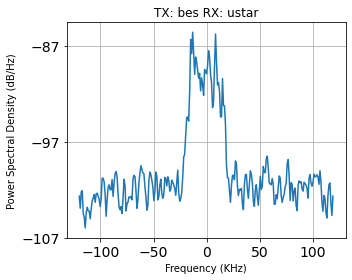

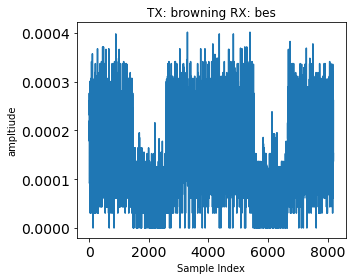

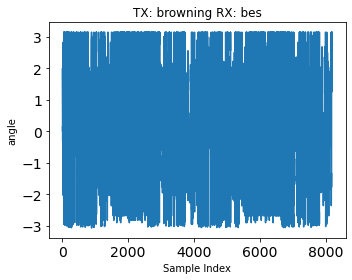

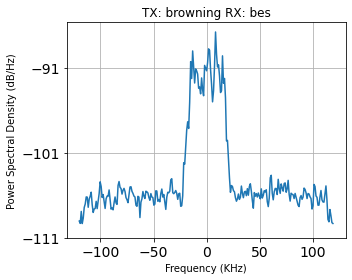

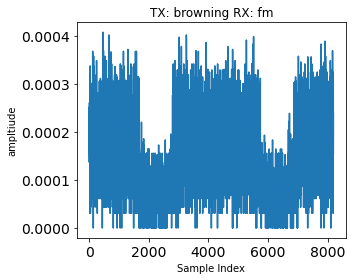

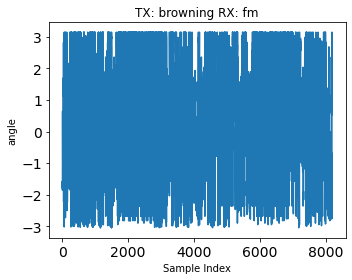

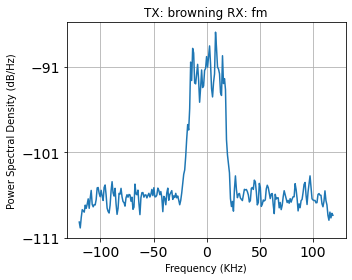

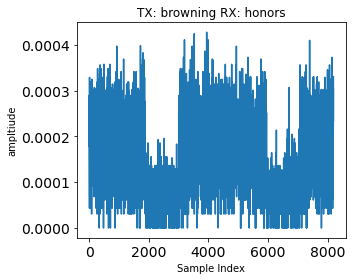

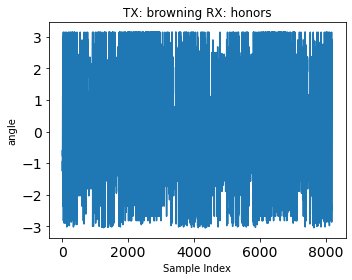

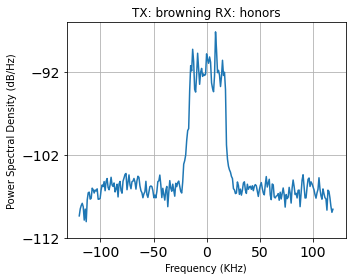

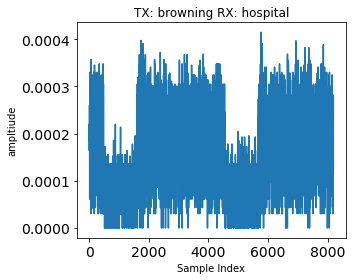

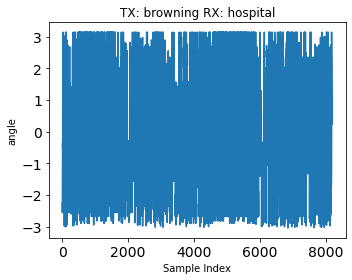

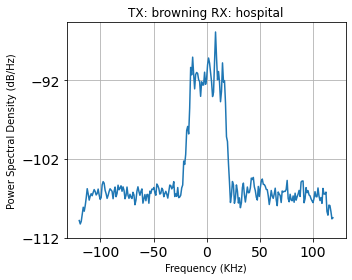

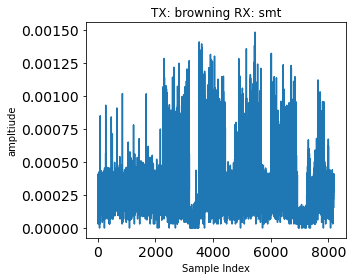

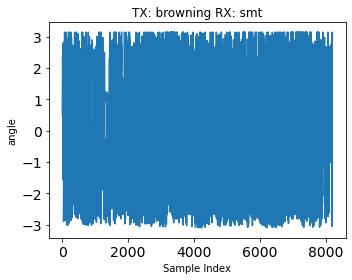

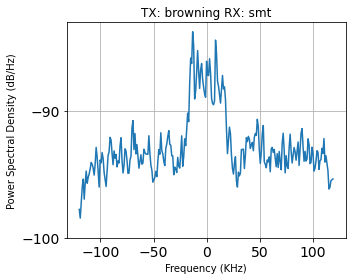

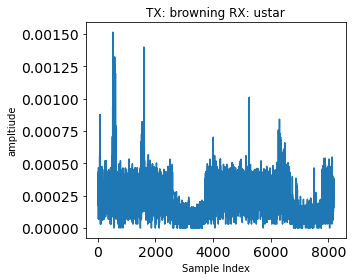

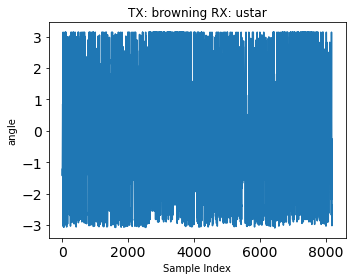

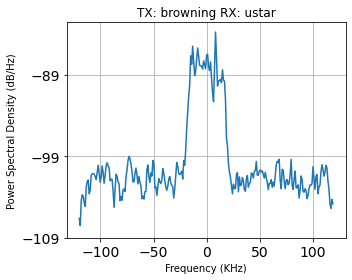

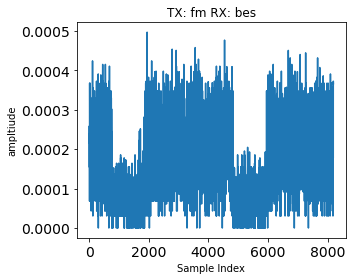

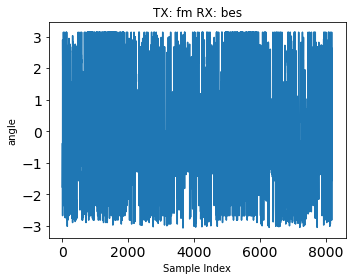

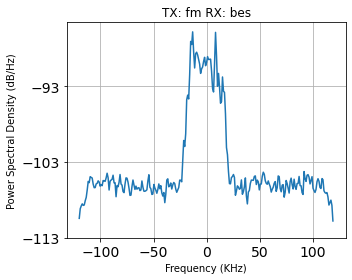

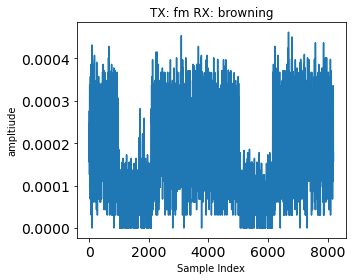

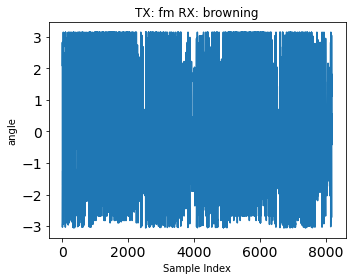

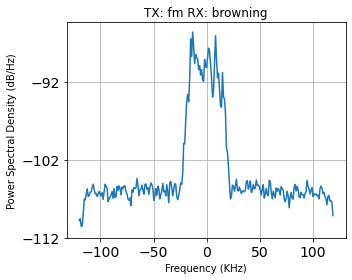

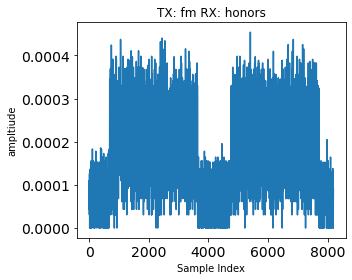

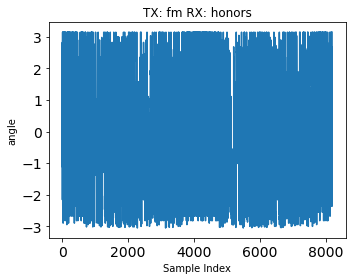

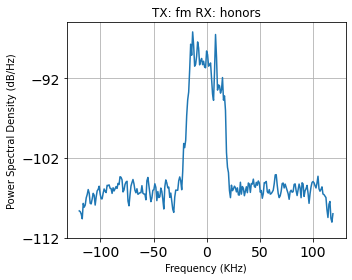

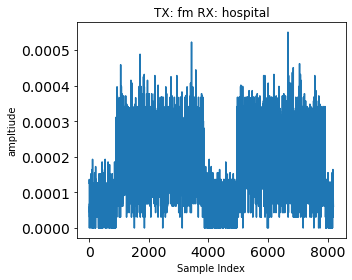

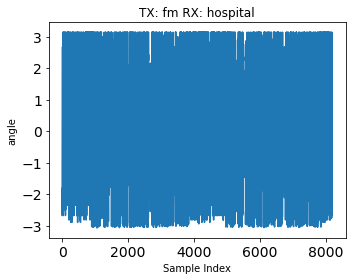

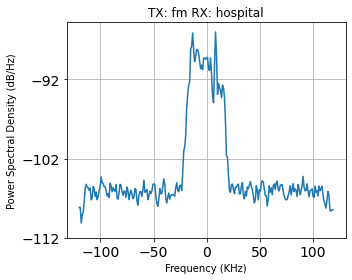

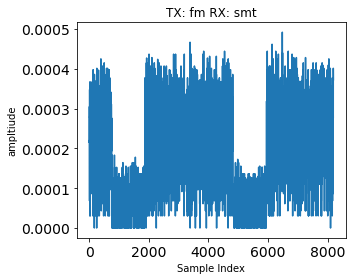

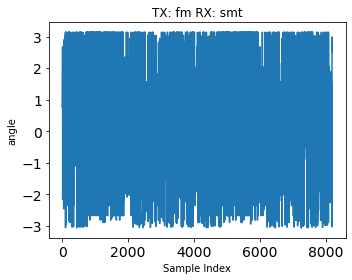

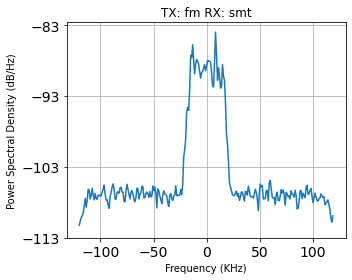

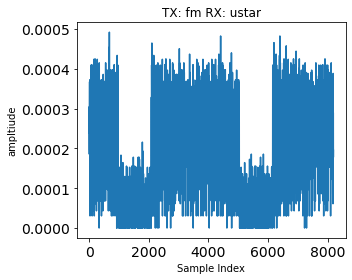

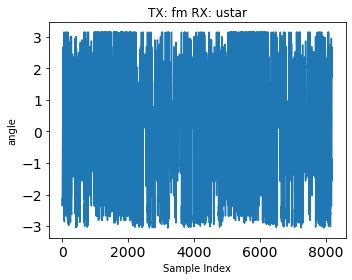

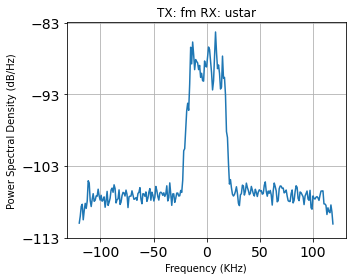

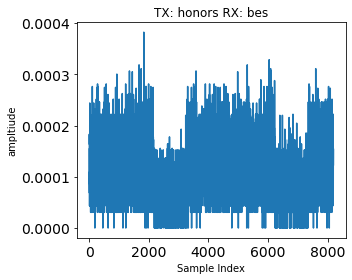

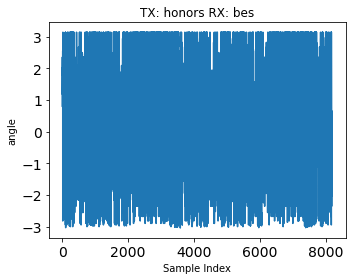

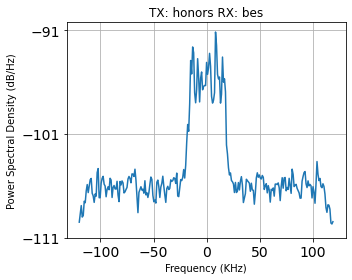

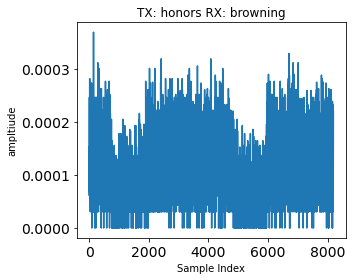

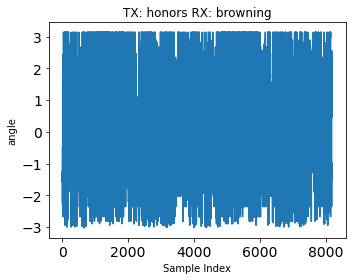

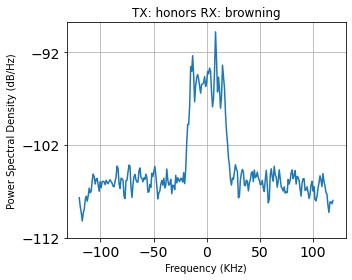

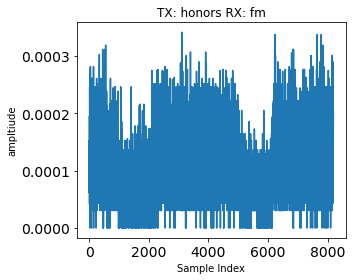

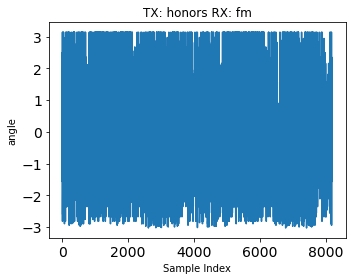

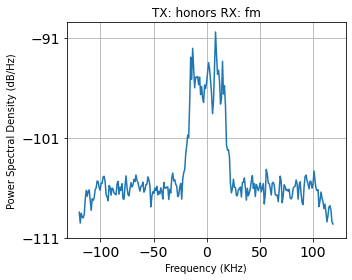

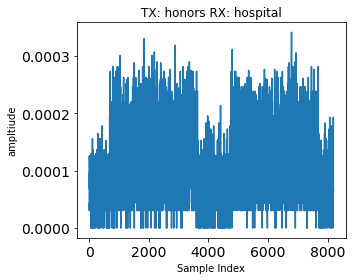

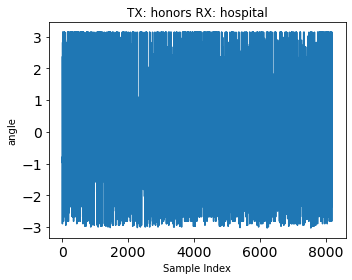

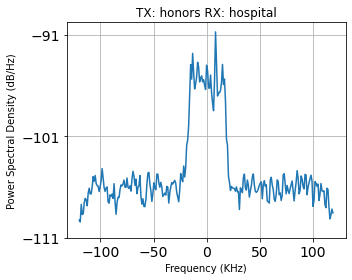

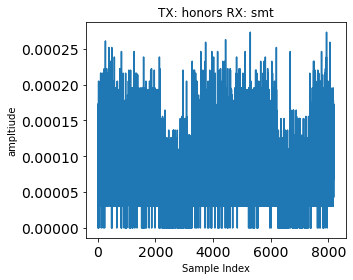

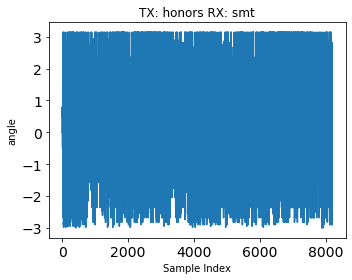

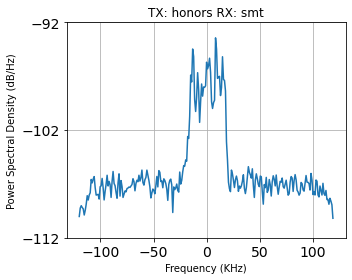

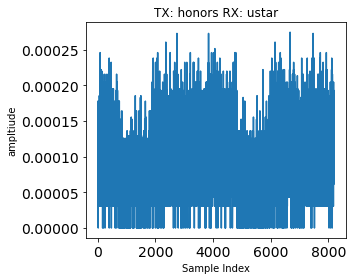

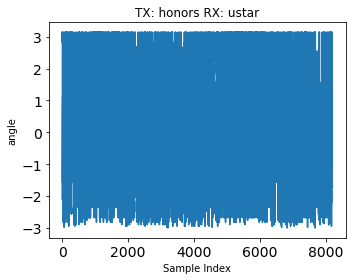

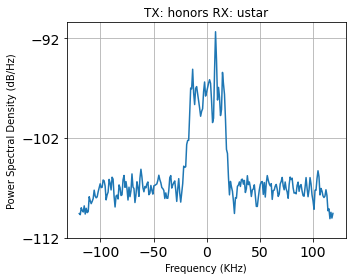

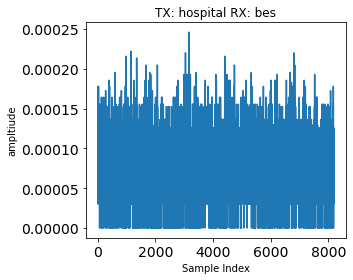

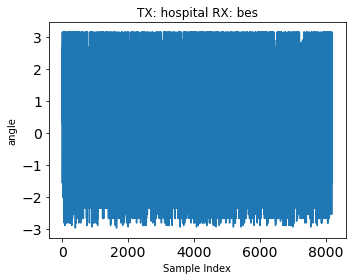

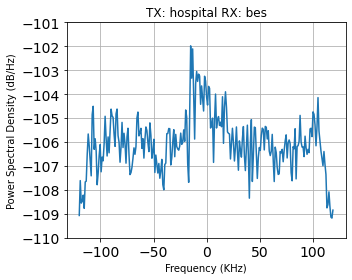

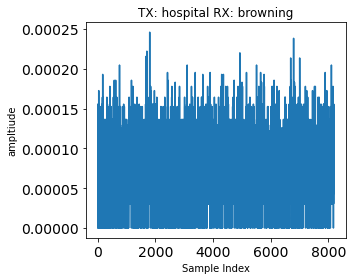

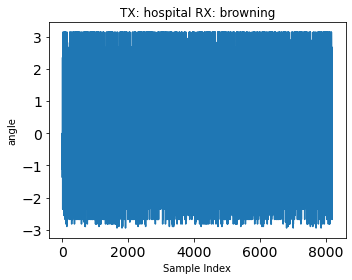

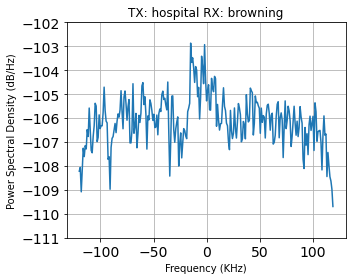

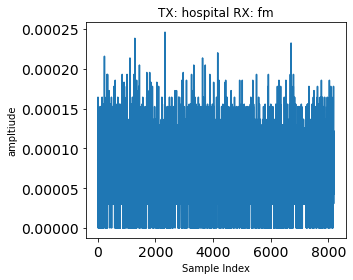

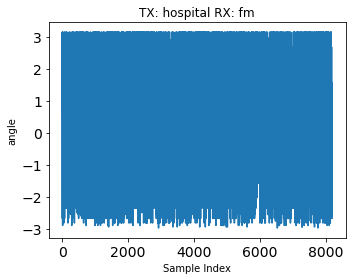

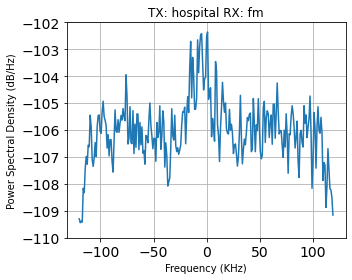

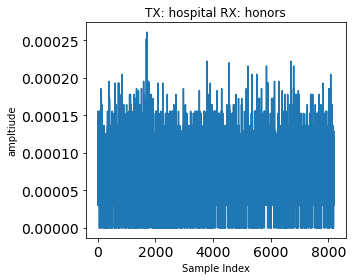

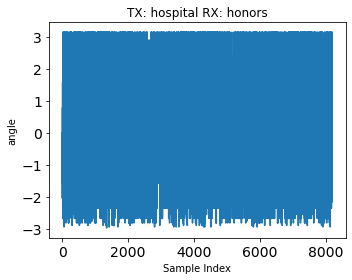

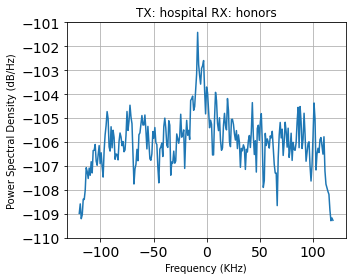

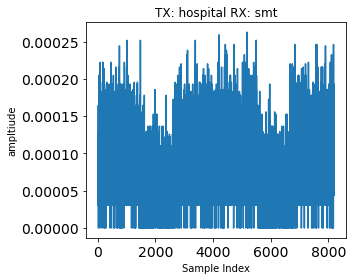

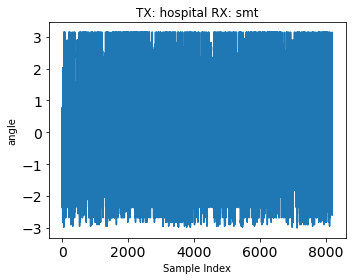

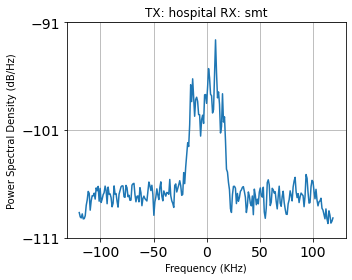

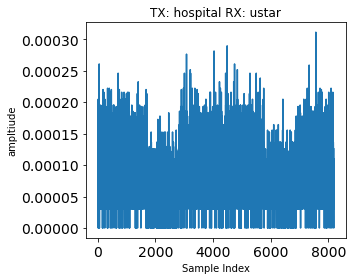

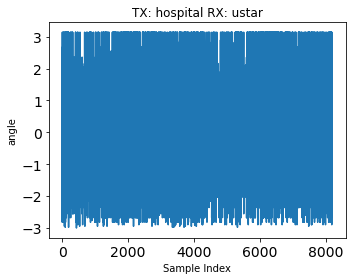

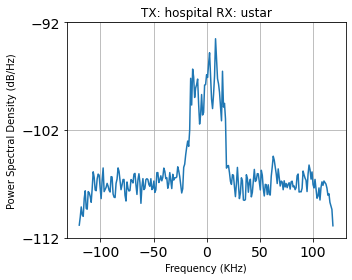

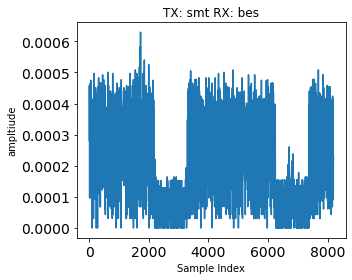

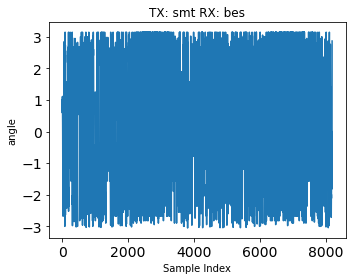

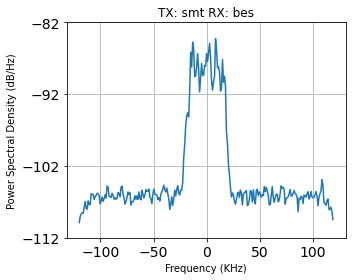

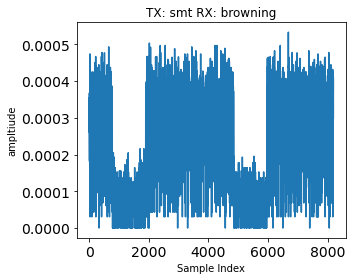

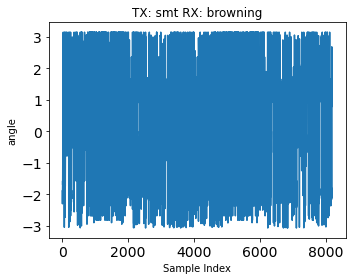

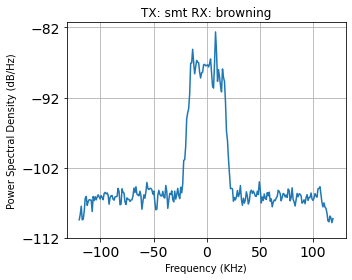

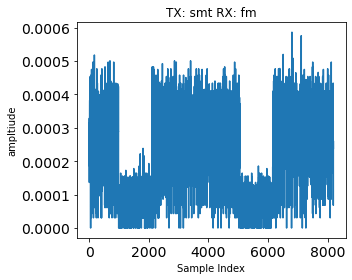

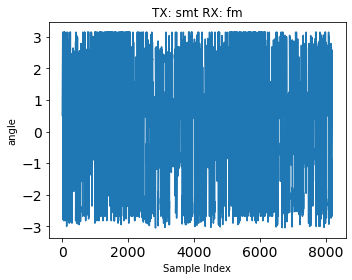

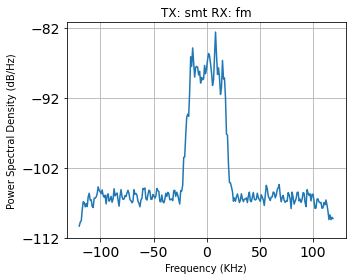

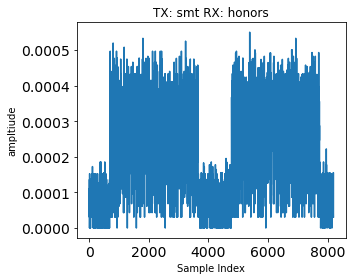

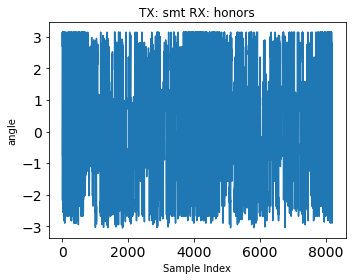

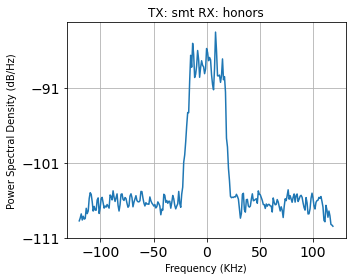

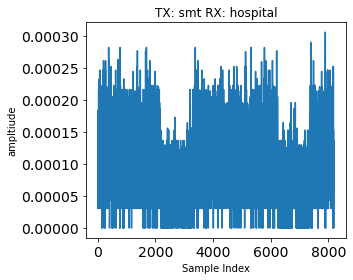

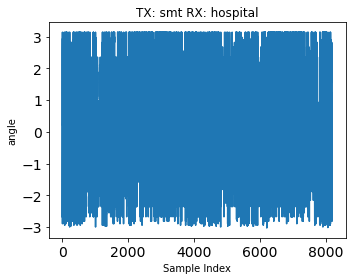

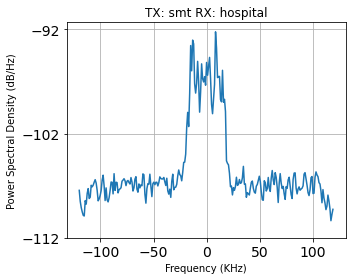

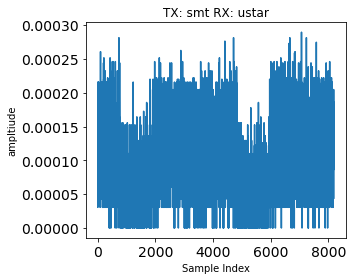

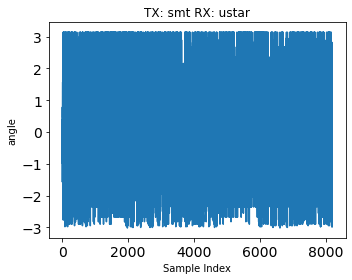

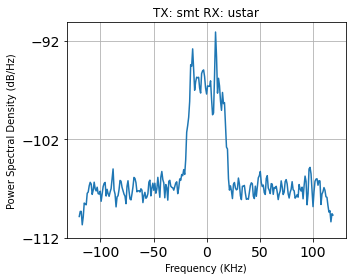

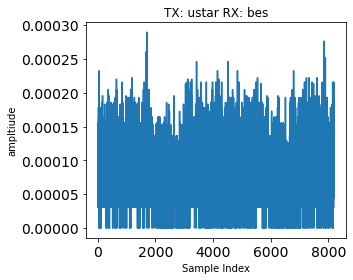

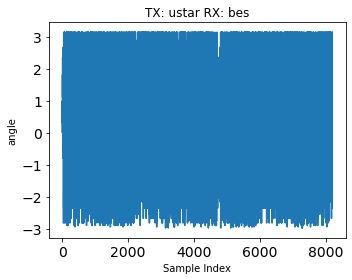

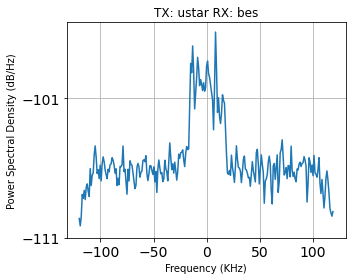

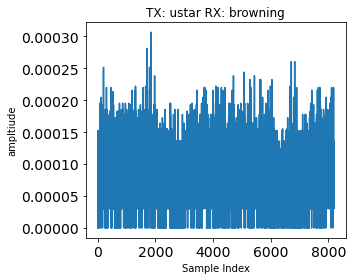

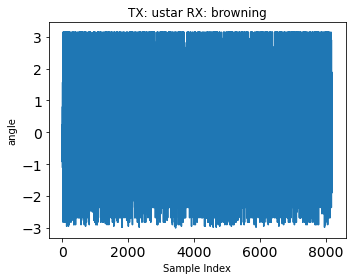

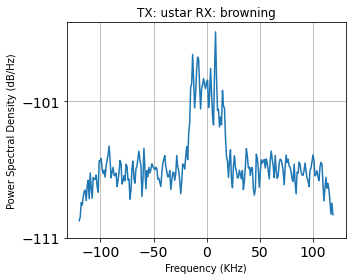

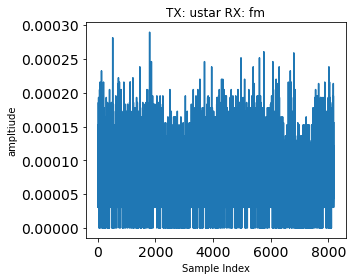

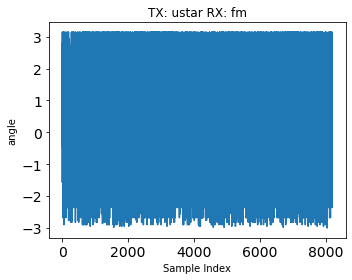

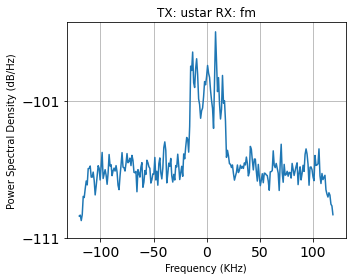

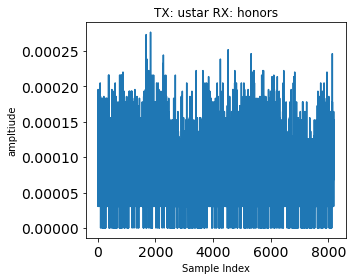

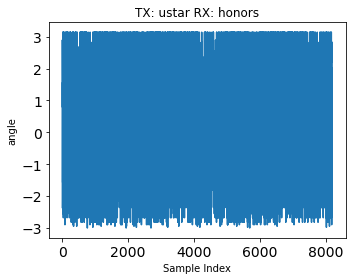

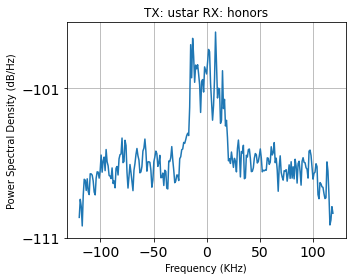

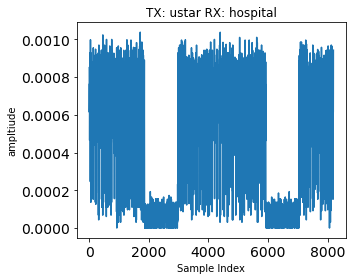

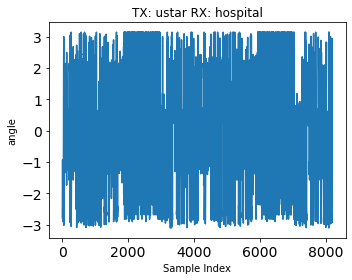

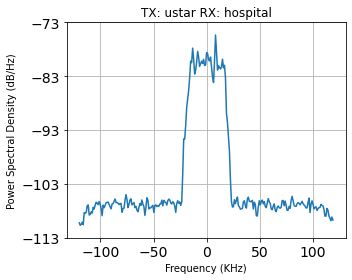

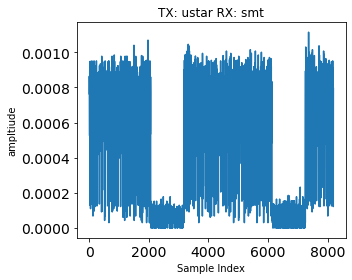

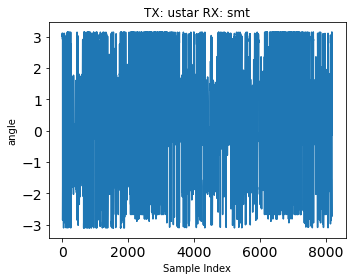

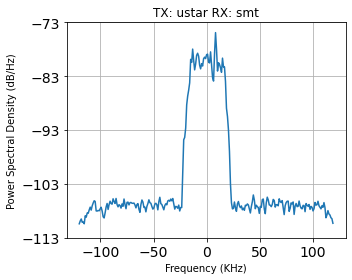

In [1540]:
# plot all links
plotAllLinks(rx_data, txrxloc)

## Pick Transmitter - Receiver Pair

In [1541]:
# Pick one received signal to demodulate
txloc = 'cbrssdr1-hospital-comp'
rxloc = 'cbrssdr1-honors-comp'

rx_data[txloc] = np.vstack(rx_data[txloc])
txloc_arr = np.array(txrxloc[txloc])
print('[DEBUG] np.shape(rx_data[txloc])', np.shape(rx_data[txloc]))
print('[DEBUG] txloc_arr', txloc_arr[txloc_arr==rxloc])
for i in range(rxrepeat-1):
    # The dictionary element is a list with one element.
    # Then, there are multiple received signals, pick one
    rx0 = rx_data[txloc][txloc_arr==rxloc][i]
    print('\nLink: {} to {}'.format(txloc, txloc_arr[txloc_arr==rxloc][i]))

[DEBUG] np.shape(rx_data[txloc]) (24, 8192)
[DEBUG] txloc_arr ['cbrssdr1-honors-comp' 'cbrssdr1-honors-comp' 'cbrssdr1-honors-comp'
 'cbrssdr1-honors-comp']

Link: cbrssdr1-hospital-comp to cbrssdr1-honors-comp

Link: cbrssdr1-hospital-comp to cbrssdr1-honors-comp

Link: cbrssdr1-hospital-comp to cbrssdr1-honors-comp


## Low Pass Filtering to out_of_band frequency components

<Figure size 432x288 with 0 Axes>

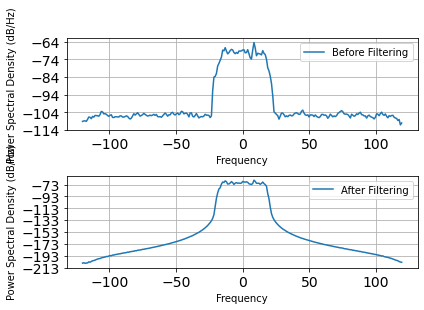

In [1542]:
### low-pass filter
# filtered_rx0 = lowpss_filter(rx0)
# filtered_rx0 = low_pass_kaiser(rx0)
stopband_attenuation = 60.0
transition_bandwidth = 0.05
filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
cutoff_norm = 0.15
# Create the filter coefficients
taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
# Use the filter on the received signal
filtered_rx0 = signal.lfilter(taps, 1.0, rx0)

# Plot psd of received signal before and after filtering
plt.figure()
fig, subfigs = plt.subplots(2,1)

subfigs[0].psd(rx0, Fs = 240, label='Before Filtering')
subfigs[0].legend()
subfigs[1].psd(filtered_rx0, Fs = 240, label='After Filtering')
subfigs[1].legend()
plt.tight_layout()
plt.show()

## Preamble synchronization

In [1543]:
# PURPOSE: create a modulated signal with the defined preamble
# INPUT: A (sqrt value for modulation), N, alpha, Lp (for srrc)
# OUTPUT: modulated preamble signal & srrc pulse
def createPreambleSignal(A, N, alpha, Lp):

    # We defined the preamble as this repeating bit signal:
    preamble     = np.tile([1, 1, 0, 0], 16)

    ###########################################
    ### Signal Generation
    ### INPUT: binary data
    ### OUTPUT: 4-ary data (0..3) values
    data = binary2mary(preamble, 4)

    ###########################################
    ### Modulation
    ### INPUT: data
    ### OUTPUT: modulated values, x
    inputVec   = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]
    xI         = lut(data, inputVec, outputVecI)
    xQ         = lut(data, inputVec, outputVecQ)

    ###########################################
    ### Upsample
    ### INPUT: modulated values, x
    ### OUTPUT: modulated values at sampling rate, x_s
    x_s_I = oversample(xI, N)
    x_s_Q = oversample(xQ, N)

    ###########################################
    ### Pulse-shape filter
    ### INPUT: modulated values at sampling rate, x_s
    ### OUTPUT: baseband transmit signal s
    pulse = SRRC(alpha, N, Lp)
    s_0_I = np.convolve(x_s_I, pulse, mode='full')
    s_0_Q = np.convolve(x_s_Q, pulse, mode='full')

    return (s_0_I + 1j*s_0_Q), pulse

In [1544]:
# PURPOSE: perform preamble synchronization
#          Uses the (complex-valued) preamble signal. The cross-correlation 
#          of the preamble signal and the received signal (at the time
#          when the preamble is received) should have highest magnitude
#          at the index delay where the preamble approximately starts.  
# INPUT:   rx0: received signal (with a frequency offset)
#          preambleSignal: complex, known, transmitted preamble signal 
# OUTPUT:  lagIndex: the index of rx0 where the preamble signal has highest 
#              cross-correlation
#
def crossCorrelationMax(rx0, preambleSignal):

    # Cross correlate with the preamble to find it in the noisy signal
    lags      = signal.correlation_lags(len(rx0), len(preambleSignal), mode='same')
    xcorr_out = signal.correlate(rx0, preambleSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)
    # There may be two preambles because the packet repeats. 
    # Pick only a peak in the first half
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)//2])
    lagIndex = lags[maxIndex]

    print('Max crosscorrelation with preamble at lag ' + str(lagIndex))

    # Plot the selected signal.
    plt.figure()
    fig, subfigs = plt.subplots(2,1)

    subfigs[0].plot(np.real(rx0), label='Real RX Signal')
    subfigs[0].plot(np.imag(rx0), label='Imag RX Signal')
    subfigs[0].plot(range(lagIndex,lagIndex+len(preambleSignal)),0.004*np.real(preambleSignal), label='Preamble')
    subfigs[0].legend()
    subfigs[1].plot(lags, xcorr_mag, label='|X-Correlation|')
    plt.xlabel('Sample Index', fontsize=14)
    plt.tight_layout()

    return lagIndex

Max crosscorrelation with preamble at lag 3919


<Figure size 432x288 with 0 Axes>

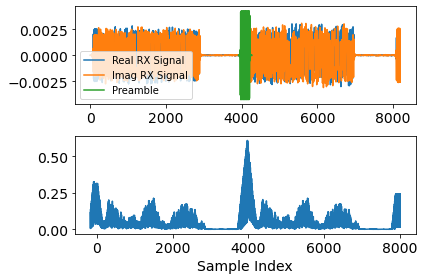

In [1545]:
A = np.sqrt(9/2)
N = 8
alpha = 0.5
Lp = 6
preambleSignal, pulse = createPreambleSignal(A, N, alpha, Lp)
lagIndex = crossCorrelationMax(filtered_rx0, preambleSignal)

## Estimation and Correction of Frequency Offset

In [1546]:
# PURPOSE: perform frequency offset estimation and correction.
#          Uses the (complex-valued) preamble signal. The product of 
#          the preamble signal and the received signal (at the time
#          when the preamble is received) has a frequency component near
#          zero at the frequency offset.  Find it from the max of the DFT.
#          We need a very fine resolution on that frequency, so we don't
#          use the FFT, we calculate it from the DFT definition.
# INPUT:   rx0: received signal (with a frequency offset)
#          preambleSignal: complex, known, transmitted preamble signal 
#          lagIndex: the index of rx0 where the preamble signal has highest 
#              cross-correlation
# OUTPUT:  rx1: Frequency-corrected received signal
#          frequencyOffset
#
def estimateFrequencyOffset(rx0, preambleSignal, lagIndex,debug=False):

    # Estimate a frequency offset using the known preamble signal
    if len(preambleSignal) < 200:
        print("estimateFrequencyOffset: Error in Preamble Signal Length")

    # if you don't discard the start and end of the preamble signal, it
    # can overlap with the synch word at its tail end, and this will
    # cause some errors in the frequency estimate.
    discardSamples = 60
    middle_of_preamble = preambleSignal[discardSamples:-discardSamples]
    N        = len(middle_of_preamble)
    # taking the max of 0 and lagIndex+discardSamples for start >=0 rx0 index
    startInd = max(0, lagIndex+discardSamples)
    rx0_part = np.conjugate(rx0[startInd:(startInd + N)])
    prod_rx0_preamble = rx0_part*middle_of_preamble

    # Frequencies at which freq content is calc'ed.
    # We'll multiply the generated matrix by the data to calculate PSD
    # frequencies are normalized to sampling rate
    # MUST BE SET BY USER.  For POWDER with frequency synched nodes, we
    # expect at most 200e-9 frequency offset, which at center frequency of 3.5 GHz
    # and 240k sample rate, is 3.5e9 * 200e-9 / 240e3 = 0.003.  But we can
    # be conservative and make it larger, no problem.  We want to get the offset
    # down to at most 5 Hz b/c the packet duration is about 20 ms, so that would
    # keep the drift to about 1/10 of a rotation over the whole packet.
    maxFreqOffset   = 0.010000
    deltaFreqOffset = 0.000005
    freqRange    = np.arange(-maxFreqOffset, maxFreqOffset, deltaFreqOffset)
    temp         = (-1j*2*np.pi) * freqRange
    expMat       = np.transpose(np.array([np.exp(temp*i) for i in np.arange(0,N)]))
    # print('expMat.size',expMat.size)
    # print('N',N)
    # print('len(prod_rx0_preamble)',len(prod_rx0_preamble))
    PSD_prod     = np.abs(expMat.dot(prod_rx0_preamble))**2

    #if debug:
    plt.figure()
    plt.plot(250000.0*freqRange,PSD_prod,'r.')
    plt.grid('on')
    plt.xlabel('Frequency Offset')
    plt.ylabel('sqrt PSD')
    # plt.show()

    maxIndexPSD  = np.argmax(PSD_prod)
    maxIndexFreq = freqRange[maxIndexPSD]

    print('[estimateFrequencyOffset] Frequency offset estimate: ' + str(maxIndexFreq*samp_rate) + ' Hz')

    # Do frequency correction on the input signal
    expTerm = np.exp((1j*2*np.pi * maxIndexFreq) * np.arange(len(rx0)))
    rx1 = expTerm * rx0

    return rx1, maxIndexFreq

[estimateFrequencyOffset] Frequency offset estimate: -2.5000000001018132 Hz


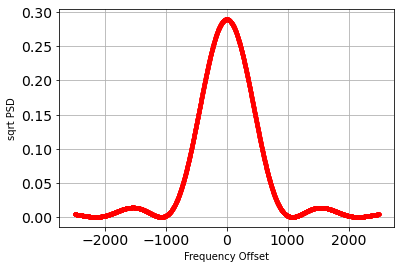

In [1547]:
rx1, freqOffsetEst = estimateFrequencyOffset(rx0, preambleSignal, lagIndex)

[estimateFrequencyOffset] Frequency offset estimate: 3.7499999998979323 Hz


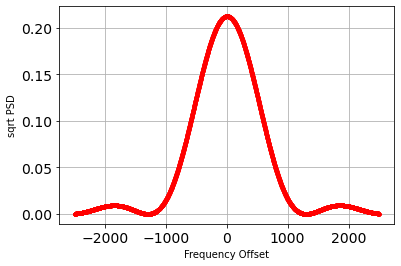

In [1548]:
rx1, freqOffsetEst = estimateFrequencyOffset(filtered_rx0, preambleSignal, lagIndex)

## Phase synchronization and further filetering

In [1549]:
def DD_carrier_sync(z, M, BnTs, zeta=0.707, mod_type = 'MPSK', type = 0, open_loop = False):
    """
    source:  https://scikit-dsp-comm.readthedocs.io/en/latest/synchronization.html
    z_prime,a_hat,e_phi = DD_carrier_sync(z,M,BnTs,zeta=0.707,type=0)
    Decision directed carrier phase tracking
    
    INPUT
    ----    
        z = complex baseband PSK signal at one sample per symbol
        M = The PSK modulation order, i.e., 2, 8, or 8.
        BnTs = time bandwidth product of loop bandwidth and the symbol period,
               thus the loop bandwidth as a fraction of the symbol rate.
        zeta = loop damping factor
        type = Phase error detector type: 0 <> ML, 1 <> heuristic
    
    OUTPUT
    ----
        z_prime = phase rotation output (like soft symbol values)
        a_hat = the hard decision symbol values landing at the constellation
               values
        e_phi = the phase error e(k) into the loop filter
        Ns = Nominal number of samples per symbol (Ts/T) in the carrier 
            phase tracking loop, almost always 1
        Kp = The phase detector gain in the carrier phase tracking loop; 
            This value depends upon the algorithm type. For the ML scheme
            described at the end of notes Chapter 9, A = 1, K 1/sqrt(2),
            so Kp = sqrt(2).
    
    Mark Wickert July 2014
    Updated for improved MPSK performance April 2020
    Added experimental MQAM capability April 2020
    Motivated by code found in M. Rice, Digital Communications A Discrete-Time 
    Approach, Prentice Hall, New Jersey, 2009. (ISBN 978-0-13-030497-1).
    """
    Ns = 1
    z_prime = np.zeros_like(z)
    a_hat = np.zeros_like(z)
    e_phi = np.zeros(len(z))
    theta_h = np.zeros(len(z))
    theta_hat = 0

    # Tracking loop constants
    Kp = 1 # What is it for the different schemes and modes?
    K0 = 1 
    K1 = 4*zeta/(zeta + 1/(4*zeta))*BnTs/Ns/Kp/K0 # C.46 in the rice book
    K2 = 4/(zeta + 1/(4*zeta))**2*(BnTs/Ns)**2/Kp/K0
    
    # Initial condition
    vi = 0
    # Scaling for MQAM using signal power
    # and known relationship for QAM.
    if mod_type == 'MQAM':
        z_scale = np.std(z) * np.sqrt(3/(2*(M-1)))
        z = z/z_scale
    for nn in range(len(z)):
        # Multiply by the phase estimate exp(-j*theta_hat[n])
        z_prime[nn] = z[nn]*np.exp(-1j*theta_hat)
        if mod_type == 'MPSK':
            if M == 2:
                a_hat[nn] = np.sign(z_prime[nn].real) + 1j*0
            elif M == 4:
                a_hat[nn] = (np.sign(z_prime[nn].real) + \
                             1j*np.sign(z_prime[nn].imag))/np.sqrt(2)
            elif M > 4:
                # round to the nearest integer and fold to nonnegative
                # integers; detection into M-levels with thresholds at mid points.
                a_hat[nn] = np.mod((np.rint(np.angle(z_prime[nn])*M/2/np.pi)).astype(np.int),M)
                a_hat[nn] = np.exp(1j*2*np.pi*a_hat[nn]/M)
            else:
                print('M must be 2, 4, 8, etc.')
        elif mod_type == 'MQAM':
            # Scale adaptively assuming var(x_hat) is proportional to 
            if M ==2 or M == 4 or M == 16 or M == 64 or M == 256:
                x_m = np.sqrt(M)-1
                if M == 2: x_m = 1
                # Shift to quadrant one for hard decisions 
                a_hat_shift = (z_prime[nn] + x_m*(1+1j))/2
                # Soft IQ symbol values are converted to hard symbol decisions
                a_hat_shiftI = np.int16(np.clip(np.rint(a_hat_shift.real),0,x_m))
                a_hat_shiftQ = np.int16(np.clip(np.rint(a_hat_shift.imag),0,x_m))
                # Shift back to antipodal QAM
                a_hat[nn] = 2*(a_hat_shiftI + 1j*a_hat_shiftQ) - x_m*(1+1j)
            else:
                print('M must be 2, 4, 16, 64, or 256');
        if type == 0:
            # Maximum likelihood (ML) Rice
            e_phi[nn] = z_prime[nn].imag * a_hat[nn].real - \
                        z_prime[nn].real * a_hat[nn].imag
        elif type == 1:
            # Heuristic Rice
            e_phi[nn] = np.angle(z_prime[nn]) - np.angle(a_hat[nn])
            # Wrap the phase to [-pi,pi]  
            e_phi[nn] = np.angle(np.exp(1j*e_phi[nn]))
        elif type == 2:
            # Ouyang and Wang 2002 MQAM paper
            e_phi[nn] = np.imag(z_prime[nn]/a_hat[nn])
        else:
            print('Type must be 0 or 1')
        vp = K1*e_phi[nn]      # proportional component of loop filter
        vi = vi + K2*e_phi[nn] # integrator component of loop filter
        v = vp + vi        # loop filter output
        theta_hat = np.mod(theta_hat + v,2*np.pi)
        theta_h[nn] = theta_hat # phase track output array
        if open_loop:
            theta_hat = 0 # for open-loop testing
    
    # Normalize MQAM outputs
    if mod_type == 'MQAM': 
        z_prime *= z_scale
    return z_prime, a_hat, e_phi, theta_h

In [1550]:
def lowpss_filter(data):
    order = 7
    high = 0.3
    [beta, alpha] = signal.iirfilter(order, high, rp=3, btype='low', ftype='cheby1', output='ba')
    filtered_data = signal.lfilter(beta, alpha, data)
    filtered_data -= np.mean(filtered_data)
    return filtered_data

In [1551]:
def low_pass_kaiser(samples):
    stopband_attenuation = 60.0
    transition_bandwidth = 0.05
    filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
    cutoff_norm = 0.15
    # Create the filter coefficients
    taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
    # Use the filter on the received signal
    filtered_samples = signal.lfilter(taps, 1.0, samples)
    return filtered_samples

In [1552]:
# PURPOSE: Plot the signal symbol samples on a complex plane
# INPUT:   Received complex values (output of matched filter downsampled)
# OUTPUT:  none
def constellation_plot(rx4):
    # I like a square plot for the constellation so that both dimensions look equal
    plt.figure(figsize=(5,5))
    ax = plt.gca() 
    ax.set_aspect(1.0) # Make it a square 1x1 ratio plot
    plt.plot(np.real(rx4), np.imag(rx4),'ro')
    plt.ylabel('Imag(Symbol Sample)', fontsize=14)
    plt.xlabel('Real(Symbol Sample)', fontsize=14)
    plt.grid('on')
    plt.tight_layout()

theta_h [0.00101203 0.00195462 0.00283596 ... 0.9089232  0.90771702 0.90644853]


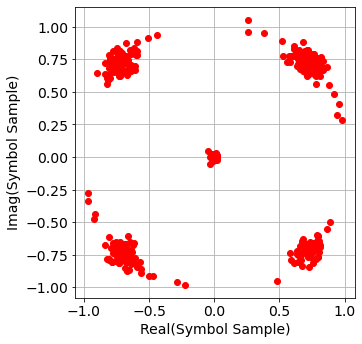

In [1553]:

###########################################
# Matched filter
# INPUT: frequency synchronized received signal rx1
# OUTPUT: matched-filtered signal rx2

rx2 = signal.lfilter(pulse, 1, rx1)

###########################################
# Fine Frequency Offset Sync
filtered_rx2, a_hat, e_phi, theta_h = DD_carrier_sync(rx2, 4, 0.02, zeta=0.707, type=1)
# print('\n\na_hat',a_hat)
print('theta_h',theta_h/(2*np.pi))

# Plot the matched filter output in an eye diagram (looking at each symbol period)
preambleStart = lagIndex + Lp*N*2 + N  # There's also the delay b/c the pulse is this long.
# plot_eye_diagram(np.imag(rx2), N, offset=preambleStart)

if filtered_rx2[preambleStart].imag * filtered_rx2[preambleStart].real<0:
    degree = np.pi
    filtered_rx2 = filtered_rx2*np.exp(-1j*degree*1/2)

###########################################
# Downsample
# INPUT: Synched matched filter output
# OUTPUT: Symbol Samples (at n*T_sy)
rx3 = filtered_rx2[preambleStart::N]
rx3 = rx3 / np.median(np.abs(rx3))  # "AGC" to make symbol values close to +/- 1

# Ignore initial samples that are very close to the origin, compared to later samples.
startsymbol = np.where(np.abs(rx3)>0.2)[0][0]
rx4 = rx3[startsymbol:]
constellation_plot(rx4)

## Symbol Detection

In [1554]:
# PURPOSE: Find the symbols which are closest in the complex plane 
#          to the measured complex received signal values.
# INPUT:   Received r_hat values (output of matched filter downsampled),
#          and possible signal space complex values. 
# OUTPUT:  m-ary symbol indices in 0...length(outputVec)-1
def findClosestComplex(r_hat, outputVec):
    # outputVec is a 4-length vector for QPSK, would be M for M-QAM or M-PSK.
    # This checks, one symbol sample at a time,  which complex symbol value
    # is closest in the complex plane.
    data_out = [np.argmin(np.abs(r-outputVec)) for r in r_hat]
    return data_out

In [1555]:
# Purpose: Convert M-ary data to binary data
#          each m-ary value input in "data" is converted to
#          log2(M) binary values.
# INPUT: M-ary digit vector
# OUTPUT: Binary digit vector, with length equal to the number
#         of values in data multiplied by log2(M)
def mary2binary(data, M):
    length = len(data) # number of values in data
    log2M = round(np.log2(M)) # integer number of bits per data value
    format_string = '0' + str(log2M) + 'b'
    binarydata = np.zeros((1,length*log2M))
    count = 0
    for each in data:
        binval = format(int(each), format_string)
        for i in range(log2M):
            binarydata[0][count+i] = int(binval[i])
        count = count + log2M
    return binarydata

In [1556]:
outputVec = np.array([1+1j, -1+1j, 1-1j, -1-1j])
mary_out  = findClosestComplex(rx4, outputVec)
binary_out = mary2binary(mary_out,4)[0]
print('The Decoded data bits are: mary_out[0:10]',binary_out)

The Decoded data bits are: mary_out[0:10] [0. 0. 1. ... 1. 0. 0.]


## Message extraction

In [1557]:
# Find the sync word in the vector of all bit decisions, and flip all bits if 
# The synch word is negated.
def phaseSyncAndExtractMessage(bits_out, syncWord, numDataBits):

    # The preamble is 64 bits, the sync word is 16 bits.  So it should be in the first
    # 100 or so bits.  If you search all bits, you may find some bit string close enough
    # to the sync word by chance in the data bits, so dont search all bit decisions.
    maxToSearch = 120 
    lagsSynch   = signal.correlation_lags(maxToSearch, len(syncWord))
    # The "2*x-1" converts from a (0,1) bit to a (-1,1) representation
    temp        = signal.correlate(2*bits_out[:maxToSearch]-1, 2*syncWord-1)
    maxIndexSync = np.argmax(np.abs(temp))
    maxSync     = temp[maxIndexSync]
    # We never did phase synchronization. 
    # A 180 degree phase error would result in all bits being negated.
    if maxSync < 0:   
        final_bits_out = 1 - bits_out
    else:
        final_bits_out = bits_out

    dataBitsStartIndex = lagsSynch[maxIndexSync] + len(syncWord)
    if dataBitsStartIndex+numDataBits < len(final_bits_out):
        data_bits = final_bits_out[dataBitsStartIndex:(dataBitsStartIndex+numDataBits)]
    else:
        data_bits = final_bits_out[dataBitsStartIndex:]
        print("Error: The packet extended beyond the end of the sample file.")
    return data_bits

In [1558]:
def binvector2str(binvector):
    #binvector = binvector[0]
    length = len(binvector)
    eps = np.finfo('float').eps
    if abs(length/7 - round(length/7)) > eps:
        print('Length of bit stream must be a multiple of 7 to convert to a string.')
    # Each character requires 7 bits in standard ASCII
    num_characters = round(length/7)
    # Maximum value is first in the vector. Otherwise would use 0:1:length-1
    start = 6
    bin_values = []
    while start >= 0:
        bin_values.append(int(math.pow(2,start)))
        start = start - 1
    bin_values = np.array(bin_values)
    bin_values = np.transpose(bin_values)
    str_out = '' # Initialize character vector
    for i in range(num_characters):
        single_char = binvector[i*7:i*7+7]
        value = 0
        for counter in range(len(single_char)):
            value = value + (int(single_char[counter]) * int(bin_values[counter]))
        str_out += chr(int(value))
    return str_out

In [1559]:
###########################################
# Symbol Decisions
# INPUT: Symbol Samples
# OUTPUT: Bits
outputVec = np.array([1+1j, -1+1j, 1-1j, -1-1j])
mary_out  = findClosestComplex(rx4, outputVec)
bits_out  = mary2binary(mary_out, 4)[0]

###########################################
# Sync Word Discovery and Data Bits Extraction
# INPUT: Bit estimates from the received signal. 
#        Must have sync word used at the transmitter.
# OUTPUT: Bits from the data (the actual message)

# You have to know these things about the packet you are receiving
syncWord    = np.array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])
# Find the sync word in the vector of all bit decisions, and flip all bits if 
# The synch word is negated.
data_bits   = phaseSyncAndExtractMessage(bits_out, syncWord, len(messageBits))
extract_message = binvector2str(data_bits)

In [1560]:
###########################################################################
print('The Extracted Message Output is:\n',extract_message)
##############################################################################

The Extracted Message Output is:
 I worked all week on digital communications and all I got was this sequence of ones and zeros.
